# Imports


In [1]:
import os
import pandas as pd
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import time
import shap
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Load Data
- [Merge Admin Data with Diagnosis Data](#Merge-Admin-Data-with-Diagnosis-Data)
- [Rules](#Rules)
- [Chart Events](#Chart-Events)
- [Encoding](#Encoding)
- [Model Building](#Model-Building)
- [EDA](#EDA)



In [3]:
def db_connection(query):
    # Database connection parameters
    db_name = 'factihealth'   # Database name
    db_user = 'fh_user'  # Username
    db_password = 'Facti@874'  # Password
    db_host = 'redshift-cluster-factihealth.cuzgotkwtow6.ap-south-1.redshift.amazonaws.com'  # Cluster endpoint
    db_port = 5439  # Port
    # Connect to the database
    try:
        conn = psycopg2.connect(
            dbname=db_name,
            user=db_user,
            password=db_password,
            host=db_host,
            port=db_port
        )
        print("Connected to the database successfully")
        # Create a cursor object
        cur = conn.cursor()
        # Execute a query
        cur.execute(query)
        rows = cur.fetchall()
        
        # Get column names from the cursor description
        col_names = [desc[0] for desc in cur.description]
        
        # Create a DataFrame from the fetched rows and column names
        df = pd.DataFrame(rows, columns=col_names)
        # Close the cursor and connection
        cur.close()
        conn.close()
        
        return df
    except Exception as e:
        print(f"Database connection failed due to {e}")

In [4]:
# Get Table Data based on table name
def get_db_data(table_name, patients_ids=()):
    ''' Get Data based on the table name provided '''
    # query = f"""SELECT * FROM factihealth.mimic.{table_name} 
    #             WHERE subject_id in {patients_ids}
    #             """
    query = f"SELECT * FROM factihealth.mimic.{table_name}"
    if patients_ids:
        query += f" WHERE subject_id IN {patients_ids}"
    df = db_connection(query)
    return df

# Load Data
## ICU STAYS

In [63]:
icustays_df = get_db_data('icustays')
display(icustays_df.head())
icustays_df.shape

Connected to the database successfully


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,18106347,24305596,30588857,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2110-01-11 10:16:06,2110-01-12 17:17:47,1.292836
1,17195991,23542772,38319097,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2110-01-12 00:54:00,2110-01-14 22:07:39,2.884479
2,18780420,28977824,32140208,Neuro Surgical Intensive Care Unit (Neuro SICU),Neuro Surgical Intensive Care Unit (Neuro SICU),2110-01-17 00:28:00,2110-01-18 01:21:22,1.037060
3,15092543,28768907,38339174,Neuro Intermediate,Neuro Intermediate,2110-01-17 22:49:13,2110-01-18 17:18:51,0.770579
4,13201095,28453791,39953418,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2110-01-18 14:46:27,2110-01-25 12:42:11,6.913704


(73181, 8)

## Select 100 Patients for Model Building

In [64]:
import random

patient_id_list = sorted(icustays_df.subject_id.unique())
patient_id_list = tuple(random.sample(patient_id_list, 1000))
#patient_id_list


(10766996,
 10405426,
 11247436,
 14421108,
 12055966,
 18970801,
 15062253,
 17164782,
 14424642,
 19717699,
 18731732,
 13897094,
 13744833,
 15227532,
 15244599,
 13882726,
 15961343,
 11449055,
 17196501,
 19802902,
 19911629,
 19767462,
 16404838,
 12820433,
 11700025,
 11045506,
 19524140,
 13820433,
 10229919,
 17353916,
 16033599,
 13229857,
 10868227,
 11570162,
 15126333,
 13433123,
 14450311,
 14827055,
 10417160,
 18481777,
 19884054,
 17150837,
 15135602,
 13831349,
 19220231,
 15262844,
 18375241,
 12245786,
 11732301,
 12357364,
 17514642,
 14880219,
 18203919,
 19957636,
 11331748,
 14829397,
 18951987,
 16171347,
 19688885,
 16406473,
 14110658,
 15467408,
 16578495,
 18521952,
 17394698,
 18253212,
 12279131,
 17014959,
 19432737,
 18672042,
 15708079,
 16205555,
 14842197,
 13450897,
 16141578,
 10885585,
 15589239,
 19422102,
 12259589,
 19062856,
 17213863,
 16392471,
 14576626,
 12155030,
 17610678,
 13474571,
 11639652,
 17158826,
 16785443,
 18720863,
 10961954,
 13427313,
 13896515,
 17511989,
 16672169,
 15955544,
 12574016,
 11048241,
 17056005,
 13273041)

In [65]:
icustays_df = get_db_data('icustays', patient_id_list)
display(icustays_df.head())
icustays_df.shape

Connected to the database successfully


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,14385035,20480421,39838991,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2110-02-23 14:29:07,2110-02-25 21:43:47,2.301852
1,14385035,20480421,33592773,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2110-02-28 23:53:58,2110-03-05 00:34:55,4.028437
2,18801749,29949595,36111383,Neuro Intermediate,Neuro Intermediate,2110-04-20 16:50:00,2110-04-23 18:12:27,3.057257
3,11384605,29677676,31121735,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2110-04-24 08:52:18,2110-04-25 21:11:03,1.513021
4,16697790,26374343,35666287,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2110-06-18 14:38:08,2110-06-20 16:26:45,2.075428


(1475, 8)

In [66]:
icustays_df.subject_id.nunique()

1000

In [67]:
patients_df = get_db_data('patients', patient_id_list)
display(patients_df.head())
patients_df.shape

Connected to the database successfully


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10018328,F,83,2154,2014 - 2016,None
1,10029484,M,64,2160,2014 - 2016,None
2,10045785,M,49,2170,2017 - 2019,None
3,10090454,F,84,2169,2011 - 2013,2169-02-11
4,10122371,M,73,2167,2008 - 2010,2167-09-17


(1000, 6)

In [68]:
patients_df.subject_id.nunique()

1000

In [69]:
chartevents_df = get_db_data('chartevents', patient_id_list)
display(chartevents_df.head())
chartevents_df.shape

Connected to the database successfully


,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,10018328,23786647,31269608,4915.0,2154-04-26 22:00:00,2154-04-26 22:33:00,220045,77,77.0,bpm,0.0
1,10018328,23786647,31269608,4915.0,2154-04-26 22:00:00,2154-04-26 22:33:00,220048,SR (Sinus Rhythm),NaN,,0.0
2,10018328,23786647,31269608,4915.0,2154-04-26 22:00:00,2154-04-26 22:33:00,220210,18,18.0,insp/min,0.0
3,10018328,23786647,31269608,4915.0,2154-04-26 22:00:00,2154-04-26 22:33:00,220277,96,96.0,%,0.0
4,10018328,23786647,31269608,4915.0,2154-04-26 22:00:00,2154-04-26 22:33:00,224650,None,NaN,,0.0


(6238527, 11)

In [70]:
chartevents_df.subject_id.nunique()

1000

# Preprocessing

### Function to categorize ICD codes

In [71]:

def categorize_icd(icd):
    try:
        if 1 <= int(icd) <= 139:
            return 'Infectious and Parasitic Diseases'
        elif 140 <= int(icd) <= 239:
            return 'Neoplasms'
        elif 240 <= int(icd) <= 279:
            return 'Endocrine, Nutritional, and Metabolic Diseases'
        elif 280 <= int(icd) <= 289:
            return 'Diseases of the Blood and Blood-forming Organs'
        elif 290 <= int(icd) <= 319:
            return 'Mental Disorders'
        elif 320 <= int(icd) <= 389:
            return 'Diseases of the Nervous System and Sense Organs'
        elif 390 <= int(icd) <= 459:
            return 'Diseases of the Circulatory System'
        elif 460 <= int(icd) <= 519:
            return 'Diseases of the Respiratory System'
        elif 520 <= int(icd) <= 579:
            return 'Diseases of the Digestive System'
        elif 580 <= int(icd) <= 629:
            return 'Diseases of the Genitourinary System'
        elif 630 <= int(icd) <= 679:
            return 'Complications of Pregnancy, Childbirth, and the Puerperium'
        elif 680 <= int(icd) <= 709:
            return 'Diseases of the Skin and Subcutaneous Tissue'
        elif 710 <= int(icd) <= 739:
            return 'Diseases of the Musculoskeletal System and Connective Tissue'
        elif 740 <= int(icd) <= 759:
            return 'Congenital Anomalies'
        elif 760 <= int(icd) <= 779:
            return 'Certain Conditions Originating in the Perinatal Period'
        elif 780 <= int(icd) <= 799:
            return 'Symptoms, Signs, and Ill-defined Conditions'
        elif 800 <= int(icd) <= 999:
            return 'Injury and Poisoning'
        
    except ValueError:
        if icd[0] == 'A' or icd[0] == 'B':
            return 'Infectious and Parasitic Diseases'
        elif icd[0] == 'C':
            return 'Neoplasms'
        elif icd[0] == 'D':
            return 'Diseases of the Blood and Blood-forming Organs'
        elif icd[0] == 'E':
            return 'External causes of injury and supplemental classification'
        elif icd[0] == 'F':
            return 'Mental Disorders'
        elif icd[0] == 'G':
            return 'Diseases of the Nervous System and Sense Organs'
        elif icd[0] == 'H':
            return 'Diseases of the eye, adnexa and mastoid process'
        elif icd[0] == 'I':
            return 'Diseases of the Circulatory System'
        elif icd[0] == 'J':
            return 'Diseases of the Respiratory System'
        elif icd[0] == 'K':
            return 'Diseases of the Digestive System'
        elif icd[0] == 'L':
            return 'Diseases of the Skin and Subcutaneous Tissue'
        elif icd[0] == 'M':
            return 'Diseases of the Musculoskeletal System and Connective Tissue'
        elif icd[0] == 'N':
            return 'Diseases of the Genitourinary System'
        elif icd[0] == 'O':
            return 'Complications of Pregnancy, Childbirth, and the Puerperium'
        elif icd[0] == 'P':
            return 'Certain Conditions Originating in the Perinatal Period'
        elif icd[0] == 'Q':
            return 'Congenital Anomalies'
        elif icd[0] == 'R':
            return 'Symptoms, Signs, and Ill-defined Conditions'
        elif icd[0] == 'S' or icd[0] == 'T' :
            return 'Injury and Poisoning'
        elif icd[0] == 'U':
            return 'Codes for special purposes'
        elif icd[0] in ['V', 'W', 'X' ,'Y']:
            return 'External causes of injury and supplemental classification'
        elif icd[0] == 'Z':
            return 'Factors influencing health status and contact with health services'
 

In [72]:
## Merge Diagnosis Data with Diagnosis Code(ICD)
patients_df = patients_df[['subject_id', 'gender', 'anchor_age']]
# pat_diagn_data = pd.merge(diagnosis_icd_df, patients_df, on='subject_id', how='left')
# pat_diagn_data.drop_duplicates(inplace=True)
patients_df.head()

,subject_id,gender,anchor_age
0,10018328,F,83
1,10029484,M,64
2,10045785,M,49
3,10090454,F,84
4,10122371,M,73


In [73]:
patients_df.subject_id.nunique()

1000

### ICD CODES

- 001–139: infectious and parasitic diseases
- 140–239: neoplasms
- 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
- 280–289: diseases of the blood and blood-forming organs
- 290–319: mental disorders
- 320–389: diseases of the nervous system and sense organs
- 390–459: diseases of the circulatory system
- 460–519: diseases of the respiratory system
- 520–579: diseases of the digestive system
- 580–629: diseases of the genitourinary system
- 630–679: complications of pregnancy, childbirth, and the puerperium
- 680–709: diseases of the skin and subcutaneous tissue
- 710–739: diseases of the musculoskeletal system and connective tissue
- 740–759: congenital anomalies
- 760–779: certain conditions originating in the perinatal period
- 780–799: symptoms, signs, and ill-defined conditions
- 800–999: injury and poisoning
- E and V codes: external causes of injury and supplemental classification


***Chapter	Block	Title***
- https://www.icd10data.com/ICD10CM/Codes
- I	A00–B99	Certain infectious and parasitic diseases
- II	C00–D48	Neoplasms
- III	D50–D89	Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism
- IV	E00–E90	Endocrine, nutritional and metabolic diseases
- V	F00–F99	Mental and behavioural disorders
- VI	G00–G99	Diseases of the nervous system
- VII	H00–H59	Diseases of the eye and adnexa
- VIII	H60–H95	Diseases of the ear and mastoid process
- IX	I00–I99	Diseases of the circulatory system
- X	J00–J99	Diseases of the respiratory system
- XI	K00–K93	Diseases of the digestive system
- XII	L00–L99	Diseases of the skin and subcutaneous tissue
- XIII	M00–M99	Diseases of the musculoskeletal system and connective tissue
- XIV	N00–N99	Diseases of the genitourinary system
- XV	O00–O99	Pregnancy, childbirth and the puerperium
- XVI	P00–P96	Certain conditions originating in the perinatal period
- XVII	Q00–Q99	Congenital malformations, deformations and chromosomal abnormalities
- XVIII	R00–R99	Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified
- XIX	S00–T98	Injury, poisoning and certain other consequences of external causes
- XX	V01–Y98	External causes of morbidity and mortality
- XXI	Z00–Z99	Factors influencing health status and contact with health services
- XXII	U00–U99	Codes for special purposes

## Merge Admission Data with Diagnosis Data

In [74]:
icustays_df.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,14385035,20480421,39838991,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2110-02-23 14:29:07,2110-02-25 21:43:47,2.301852
1,14385035,20480421,33592773,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2110-02-28 23:53:58,2110-03-05 00:34:55,4.028437
2,18801749,29949595,36111383,Neuro Intermediate,Neuro Intermediate,2110-04-20 16:50:00,2110-04-23 18:12:27,3.057257
3,11384605,29677676,31121735,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2110-04-24 08:52:18,2110-04-25 21:11:03,1.513021
4,16697790,26374343,35666287,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2110-06-18 14:38:08,2110-06-20 16:26:45,2.075428


In [75]:
# Group by 'subject_id' and count occurrences of 'hadm_id'
grouped = icustays_df.groupby('subject_id')['hadm_id'].size()

# Filter out counts greater than 3
result = grouped[grouped > 3]
result

subject_id
10476891     4
11164525     5
11474065     5
11761621     9
11922236     4
12165269     6
12246674     4
12453404     5
12490757     4
12952453     4
13051530     4
13188963    10
13198542     7
14281506     4
14297125     4
14785160     5
14874072     4
14976423     5
14994182     5
15477562     4
15746911     6
16074678     5
16218486     7
16320616     4
16323275     4
16846280     6
17399295    12
17513170     4
17589211     5
17937834    24
18043820     4
18044092     4
18628103     4
18754359     4
18779408     4
18843829     4
18855147     4
19020074     4
19052042     5
19344311     4
19420214     5
19454978     5
19735459     9
Name: hadm_id, dtype: int64

In [76]:
admin_diag = pd.merge(icustays_df, patients_df, on=['subject_id'], 
                          how='left')
print(admin_diag.shape)
admin_diag.head()

(1475, 10)


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,gender,anchor_age
0,14385035,20480421,39838991,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2110-02-23 14:29:07,2110-02-25 21:43:47,2.301852,M,80
1,14385035,20480421,33592773,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2110-02-28 23:53:58,2110-03-05 00:34:55,4.028437,M,80
2,18801749,29949595,36111383,Neuro Intermediate,Neuro Intermediate,2110-04-20 16:50:00,2110-04-23 18:12:27,3.057257,F,91
3,11384605,29677676,31121735,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2110-04-24 08:52:18,2110-04-25 21:11:03,1.513021,M,49
4,16697790,26374343,35666287,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2110-06-18 14:38:08,2110-06-20 16:26:45,2.075428,M,64


In [77]:
## Convert Time to Date
admin_diag['intime'] = pd.to_datetime(admin_diag['intime'])
admin_diag['admitdate'] = admin_diag['intime'].dt.date

# Sort Values on the admin time
admin_diag.sort_values(['subject_id', 'intime'], inplace=True)

## Get the time difference
admin_diag['admitdate_diff'] = admin_diag.groupby('subject_id')['intime'].diff()

# Replace 0s with NaN
admin_diag['admitdate_diff'] = admin_diag['admitdate_diff'].replace(pd.Timedelta(0), np.nan)

# Forward fill NaN values
admin_diag['admitdate_diff'] = admin_diag['admitdate_diff'].fillna(method='ffill')
print(admin_diag.shape)
admin_diag.head()

(1475, 12)


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,gender,anchor_age,admitdate,admitdate_diff
1408,10004720,22081550,35009126,Surgical Intensive Care Unit (SICU),Medical Intensive Care Unit (MICU),2186-11-12 19:55:00,2186-11-17 21:15:55,5.056192,M,61,2186-11-12,NaT
691,10018328,23786647,31269608,Neuro Stepdown,Neuro Stepdown,2154-04-24 23:03:44,2154-05-02 15:55:21,7.702512,F,83,2154-04-24,NaT
593,10019957,28761725,37708849,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2135-11-11 12:41:54,2135-11-13 11:29:47,1.949919,M,72,2135-11-11,NaT
804,10029484,20764029,35396193,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2160-11-08 05:23:00,2160-11-08 21:04:55,0.654109,M,64,2160-11-08,NaT
65,10034553,26774222,36618406,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2110-06-23 19:32:11,2110-06-25 15:05:04,1.814502,F,75,2110-06-23,NaT


In [78]:
# Define boolean conditions for each range
admin_diag['<10'] = admin_diag['admitdate_diff'] <= pd.Timedelta(days=10)
admin_diag['<30'] = (admin_diag['admitdate_diff'] <= pd.Timedelta(days=30))
admin_diag['>60'] = admin_diag['admitdate_diff'] > pd.Timedelta(days=60)

# Convert boolean values to integers (0 and 1)
admin_diag['<10'] = admin_diag['<10'].astype(int)
admin_diag['<30'] = admin_diag['<30'].astype(int)
admin_diag['>60'] = admin_diag['>60'].astype(int)
## Convert to Days
admin_diag['admitdate_diff'] = admin_diag['admitdate_diff'].dt.days
admin_diag.tail()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,gender,anchor_age,admitdate,admitdate_diff,<10,<30,>60
197,19967846,21070823,32460582,Trauma SICU (TSICU),Trauma SICU (TSICU),2126-07-09 01:34:00,2126-07-10 21:52:31,1.846192,F,73,2126-07-09,1.0,1,1,0
44,19970892,25899573,38532939,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2116-06-14 16:11:17,2116-06-16 22:20:22,2.256308,M,23,2116-06-14,1.0,1,1,0
1207,19978766,28652249,31053745,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2165-01-28 00:37:24,2165-01-30 15:49:51,2.633646,M,40,2165-01-28,1.0,1,1,0
17,19984573,29579818,34687507,Trauma SICU (TSICU),Trauma SICU (TSICU),2113-02-14 01:57:32,2113-02-14 17:37:02,0.652431,M,26,2113-02-14,1.0,1,1,0
1025,19989437,25692702,34737716,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2181-09-14 08:47:07,2181-09-18 22:26:10,4.568785,M,38,2181-09-14,1.0,1,1,0


In [79]:
admin_diag.shape

(1475, 15)

# APPLIED RULES

# Merge Admission Data with Chart events

In [80]:
chartevents_df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'caregiver_id', 'charttime',
       'storetime', 'itemid', 'value', 'valuenum', 'valueuom', 'warning'],
      dtype='object')

In [81]:
chartevents_df.head()

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,10018328,23786647,31269608,4915.0,2154-04-26 22:00:00,2154-04-26 22:33:00,220045,77,77.0,bpm,0.0
1,10018328,23786647,31269608,4915.0,2154-04-26 22:00:00,2154-04-26 22:33:00,220048,SR (Sinus Rhythm),NaN,,0.0
2,10018328,23786647,31269608,4915.0,2154-04-26 22:00:00,2154-04-26 22:33:00,220210,18,18.0,insp/min,0.0
3,10018328,23786647,31269608,4915.0,2154-04-26 22:00:00,2154-04-26 22:33:00,220277,96,96.0,%,0.0
4,10018328,23786647,31269608,4915.0,2154-04-26 22:00:00,2154-04-26 22:33:00,224650,None,NaN,,0.0


In [82]:
## Convert Time to Date
chartevents_df['charttime'] = pd.to_datetime(chartevents_df['charttime'])
chartevents_df['admitdate'] = chartevents_df['charttime'].dt.date
chartevents_df.head()

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,admitdate
0,10018328,23786647,31269608,4915.0,2154-04-26 22:00:00,2154-04-26 22:33:00,220045,77,77.0,bpm,0.0,2154-04-26
1,10018328,23786647,31269608,4915.0,2154-04-26 22:00:00,2154-04-26 22:33:00,220048,SR (Sinus Rhythm),NaN,,0.0,2154-04-26
2,10018328,23786647,31269608,4915.0,2154-04-26 22:00:00,2154-04-26 22:33:00,220210,18,18.0,insp/min,0.0,2154-04-26
3,10018328,23786647,31269608,4915.0,2154-04-26 22:00:00,2154-04-26 22:33:00,220277,96,96.0,%,0.0,2154-04-26
4,10018328,23786647,31269608,4915.0,2154-04-26 22:00:00,2154-04-26 22:33:00,224650,None,NaN,,0.0,2154-04-26


In [83]:
master_merged = pd.merge(admin_diag, chartevents_df, on=['hadm_id', 'stay_id', 'admitdate', 'subject_id'], how='left')
# master_merged = master_merged.fillna(0)
print(master_merged.shape)
master_merged.tail()

(840622, 23)


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,gender,anchor_age,admitdate,admitdate_diff,<10,<30,>60,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
840617,19989437,25692702,34737716,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2181-09-14 08:47:07,2181-09-18 22:26:10,4.568785,M,38,2181-09-14,1.0,1,1,0,NaN,2181-09-14 18:27:00,2181-09-14 18:29:00,225698.0,23,23.0,mEq/L,0.0
840618,19989437,25692702,34737716,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2181-09-14 08:47:07,2181-09-18 22:26:10,4.568785,M,38,2181-09-14,1.0,1,1,0,NaN,2181-09-14 18:39:00,2181-09-14 18:58:00,220545.0,36.2,36.2,%,1.0
840619,19989437,25692702,34737716,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2181-09-14 08:47:07,2181-09-18 22:26:10,4.568785,M,38,2181-09-14,1.0,1,1,0,NaN,2181-09-14 18:39:00,2181-09-14 19:41:00,220602.0,108,108.0,mEq/L,0.0
840620,19989437,25692702,34737716,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2181-09-14 08:47:07,2181-09-18 22:26:10,4.568785,M,38,2181-09-14,1.0,1,1,0,NaN,2181-09-14 18:39:00,2181-09-14 19:41:00,220645.0,138,138.0,mEq/L,0.0
840621,19989437,25692702,34737716,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2181-09-14 08:47:07,2181-09-18 22:26:10,4.568785,M,38,2181-09-14,1.0,1,1,0,NaN,2181-09-14 18:39:00,2181-09-14 19:41:00,227442.0,4.4,4.4,mEq/L,0.0


In [84]:
print(master_merged[~master_merged['valuenum'].isna()].shape)
print(master_merged[master_merged['valuenum'].isna()].shape)

(381366, 23)
(459256, 23)


## Group patient label data with hospital admissions
- [Load Data](#Load-Data)
- [Rules](#Rules)
- [Chart Events](#Chart-Events)
- [Encoding](#Encoding)
- [Model Building](#Model-Building)
- [EDA](#EDA)


In [85]:
master_merged.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los', 'gender', 'anchor_age', 'admitdate',
       'admitdate_diff', '<10', '<30', '>60', 'caregiver_id', 'charttime',
       'storetime', 'itemid', 'value', 'valuenum', 'valueuom', 'warning'],
      dtype='object')

In [86]:
## Select the required columns
columns= ['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit',
          'los', 'gender', 'anchor_age', 'admitdate_diff', 'charttime',
          'valuenum', 'valueuom', 'admitdate', '<10', '<30', '>60']

master_merged = master_merged[columns]
master_merged.head(2)

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,los,gender,anchor_age,admitdate_diff,charttime,valuenum,valueuom,admitdate,<10,<30,>60
0,10004720,22081550,35009126,Surgical Intensive Care Unit (SICU),Medical Intensive Care Unit (MICU),5.056192,M,61,NaN,2186-11-12 20:00:00,NaN,,2186-11-12,0,0,0
1,10004720,22081550,35009126,Surgical Intensive Care Unit (SICU),Medical Intensive Care Unit (MICU),5.056192,M,61,NaN,2186-11-12 20:00:00,NaN,,2186-11-12,0,0,0


In [111]:
master_merged[master_merged.subject_id==10004720]

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,los,gender,anchor_age,admitdate_diff,charttime,valuenum,valueuom,admitdate,<10,<30,>60
0,10004720,22081550,35009126,Surgical Intensive Care Unit (SICU),Medical Intensive Care Unit (MICU),5.056192,M,61,NaN,2186-11-12 20:00:00,NaN,,2186-11-12,0,0,0
1,10004720,22081550,35009126,Surgical Intensive Care Unit (SICU),Medical Intensive Care Unit (MICU),5.056192,M,61,NaN,2186-11-12 20:00:00,NaN,,2186-11-12,0,0,0
2,10004720,22081550,35009126,Surgical Intensive Care Unit (SICU),Medical Intensive Care Unit (MICU),5.056192,M,61,NaN,2186-11-12 20:00:00,NaN,,2186-11-12,0,0,0
3,10004720,22081550,35009126,Surgical Intensive Care Unit (SICU),Medical Intensive Care Unit (MICU),5.056192,M,61,NaN,2186-11-12 20:00:00,NaN,,2186-11-12,0,0,0
4,10004720,22081550,35009126,Surgical Intensive Care Unit (SICU),Medical Intensive Care Unit (MICU),5.056192,M,61,NaN,2186-11-12 20:00:00,NaN,,2186-11-12,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,10004720,22081550,35009126,Surgical Intensive Care Unit (SICU),Medical Intensive Care Unit (MICU),5.056192,M,61,NaN,2186-11-12 20:00:00,6.7,L/min,2186-11-12,0,0,0
398,10004720,22081550,35009126,Surgical Intensive Care Unit (SICU),Medical Intensive Care Unit (MICU),5.056192,M,61,NaN,2186-11-12 20:00:00,4.0,L/min,2186-11-12,0,0,0
399,10004720,22081550,35009126,Surgical Intensive Care Unit (SICU),Medical Intensive Care Unit (MICU),5.056192,M,61,NaN,2186-11-12 20:06:00,100.0,%,2186-11-12,0,0,0
400,10004720,22081550,35009126,Surgical Intensive Care Unit (SICU),Medical Intensive Care Unit (MICU),5.056192,M,61,NaN,2186-11-12 18:38:00,1.5,mmol/L,2186-11-12,0,0,0


In [87]:
master_merged.shape

(840622, 16)

In [88]:
master_merged_df = master_merged.groupby(['subject_id', 'hadm_id', 'stay_id', 'valueuom', 
                                          'valuenum']).agg({
                                                            'first_careunit': 'first',
                                                            'last_careunit': 'first',
                                                            'los': 'first',
                                                            'gender': 'first',
                                                            'anchor_age': 'first',
                                                            'admitdate_diff': 'first',
                                                            'admitdate': 'first',
                                                            '<10': 'first',
                                                            '<30': 'first',
                                                            '>60': 'first'
                                                            }).reset_index()
master_merged_df.tail()

,subject_id,hadm_id,stay_id,valueuom,valuenum,first_careunit,last_careunit,los,gender,anchor_age,admitdate_diff,admitdate,<10,<30,>60
170354,19989437,25692702,34737716,units,7.42,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),4.568785,M,38,1.0,2181-09-14,1,1,0
170355,19989437,25692702,34737716,°F,98.10,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),4.568785,M,38,1.0,2181-09-14,1,1,0
170356,19989437,25692702,34737716,°F,98.20,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),4.568785,M,38,1.0,2181-09-14,1,1,0
170357,19989437,25692702,34737716,°F,98.70,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),4.568785,M,38,1.0,2181-09-14,1,1,0
170358,19989437,25692702,34737716,°F,99.20,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),4.568785,M,38,1.0,2181-09-14,1,1,0


In [89]:
master_merged_df.shape

(170359, 15)

### Correlation between the variable and target

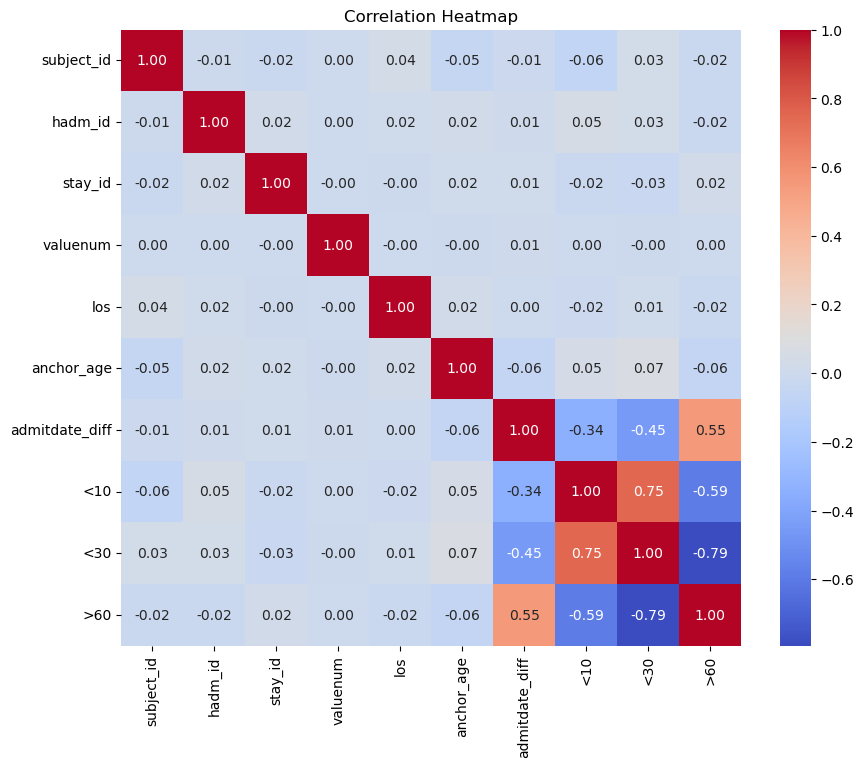

In [90]:
numeric_df = master_merged_df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [92]:
for i in ['valueuom', 'gender', 'first_careunit', 'last_careunit']:
    print(i, master_merged_df[i].nunique())

valueuom 53
gender 2
first_careunit 9
last_careunit 9


In [93]:
master_merged_df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'valueuom', 'valuenum',
       'first_careunit', 'last_careunit', 'los', 'gender', 'anchor_age',
       'admitdate_diff', 'admitdate', '<10', '<30', '>60'],
      dtype='object')

In [94]:
master_data = master_merged_df.pivot_table(index=['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit', 'los', 'gender', 'anchor_age', 'admitdate_diff', 'admitdate', '<10', '<30', '>60'], 
                          columns='valueuom', values='valuenum', aggfunc='first')

master_data.reset_index(inplace=True)
master_data.head()

valueuom,subject_id,hadm_id,stay_id,first_careunit,last_careunit,los,gender,anchor_age,admitdate_diff,admitdate,<10,<30,>60,,%,/min,IU/L,Inch,K/uL,L/min,L/min/m2,Liters,bpm,cm,cmH2O,cmH2O/L/seconds,dynes*sec/cm5,dynes*sec/cm5/m2,dynes.sec.cm-5/m2,g/dL,g/dl,g/kg,hour,insp/min,kcal/kg,kg,lbs,mA,mEq/L,mL,mL/beat,mL/m2,mOsm/kg,mV,mg/L,mg/dL,min,ml/hr,ml/kg,ml/min,mm/hr,mmHg,mmHg.,mmol/L,msec,ng/mL,pg/mL,ppm,psi,sec,ug/dL,ug/mL,umol/L,units,°C,°F
0,10115397,28605901,31831959,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),13.453345,M,85,8.0,2133-01-10,1,1,0,-3.0,26.1,NaN,NaN,NaN,19.1,4.5,NaN,NaN,60.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,8.3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,4.4,1.4,NaN,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.09,NaN,NaN,NaN,NaN,NaN,0.80,NaN,NaN,NaN,7.56,NaN,97.9
1,10122371,25615752,36824058,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),4.604005,M,73,8.0,2167-09-12,1,1,0,0.0,0.0,NaN,42.0,71.0,22.8,3.5,NaN,NaN,50.0,180.0,15.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,0.0,NaN,119.0,NaN,NaN,-5.0,1.5,NaN,NaN,NaN,NaN,NaN,1.7,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.14,NaN,0.01,20463.0,NaN,NaN,0.47,31.8,NaN,NaN,6.50,NaN,98.8
2,10132611,28996766,31179345,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2.479873,M,74,8.0,2168-02-22,1,1,0,0.0,4.9,NaN,265.0,NaN,5.7,1.5,NaN,NaN,50.0,NaN,5.0,NaN,NaN,NaN,NaN,7.0,6.1,NaN,NaN,8.0,NaN,86.3,NaN,NaN,4.7,0.0,NaN,NaN,NaN,NaN,NaN,2.7,NaN,NaN,NaN,NaN,NaN,27.0,NaN,0.97,NaN,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.39,35.6,97.2
3,10132611,28996766,32591816,Trauma SICU (TSICU),Trauma SICU (TSICU),1.805382,M,74,7.0,2168-02-29,1,1,0,0.0,88.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.0
4,10133363,24023873,31074007,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),1.029421,F,78,7.0,2113-01-10,1,1,0,0.0,85.0,NaN,NaN,NaN,NaN,11.0,NaN,NaN,40.0,9.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,147.9,NaN,NaN,4.1,NaN,NaN,NaN,NaN,NaN,NaN,1.1,NaN,NaN,NaN,NaN,NaN,28.0,NaN,1.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.26,NaN,97.9


In [95]:
master_data.shape

(1461, 66)

In [96]:
cat_columns=['gender', 'first_careunit', 'last_careunit']


master_data = pd.get_dummies(master_data, columns=cat_columns, drop_first=True)
print(master_data.shape)
master_data.fillna(0, inplace=True)
master_data.head()

(1461, 80)


,subject_id,hadm_id,stay_id,los,anchor_age,admitdate_diff,admitdate,<10,<30,>60,,%,/min,IU/L,Inch,K/uL,L/min,L/min/m2,Liters,bpm,cm,cmH2O,cmH2O/L/seconds,dynes*sec/cm5,dynes*sec/cm5/m2,dynes.sec.cm-5/m2,g/dL,g/dl,g/kg,hour,insp/min,kcal/kg,kg,lbs,mA,mEq/L,mL,mL/beat,mL/m2,mOsm/kg,mV,mg/L,mg/dL,min,ml/hr,ml/kg,ml/min,mm/hr,mmHg,mmHg.,mmol/L,msec,ng/mL,pg/mL,ppm,psi,sec,ug/dL,ug/mL,umol/L,units,°C,°F,gender_M,first_careunit_Coronary Care Unit (CCU),first_careunit_Medical Intensive Care Unit (MICU),first_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU),first_careunit_Neuro Intermediate,first_careunit_Neuro Stepdown,first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU),first_careunit_Surgical Intensive Care Unit (SICU),first_careunit_Trauma SICU (TSICU),last_careunit_Coronary Care Unit (CCU),last_careunit_Medical Intensive Care Unit (MICU),last_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU),last_careunit_Neuro Intermediate,last_careunit_Neuro Stepdown,last_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU),last_careunit_Surgical Intensive Care Unit (SICU),last_careunit_Trauma SICU (TSICU)
0,10115397,28605901,31831959,13.453345,85,8.0,2133-01-10,1,1,0,-3.0,26.1,0.0,0.0,0.0,19.1,4.5,0.0,0.0,60.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,8.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.4,1.4,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.09,0.0,0.00,0.0,0.0,0.0,0.80,0.0,0.0,0.0,7.56,0.0,97.9,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,10122371,25615752,36824058,4.604005,73,8.0,2167-09-12,1,1,0,0.0,0.0,0.0,42.0,71.0,22.8,3.5,0.0,0.0,50.0,180.0,15.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,119.0,0.0,0.0,-5.0,1.5,0.0,0.0,0.0,0.0,0.0,1.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.14,0.0,0.01,20463.0,0.0,0.0,0.47,31.8,0.0,0.0,6.50,0.0,98.8,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,10132611,28996766,31179345,2.479873,74,8.0,2168-02-22,1,1,0,0.0,4.9,0.0,265.0,0.0,5.7,1.5,0.0,0.0,50.0,0.0,5.0,0.0,0.0,0.0,0.0,7.0,6.1,0.0,0.0,8.0,0.0,86.3,0.0,0.0,4.7,0.0,0.0,0.0,0.0,0.0,0.0,2.7,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0.97,0.0,0.38,0.0,0.0,0.0,0.00,0.0,0.0,0.0,7.39,35.6,97.2,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False
3,10132611,28996766,32591816,1.805382,74,7.0,2168-02-29,1,1,0,0.0,88.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,98.0,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True
4,10133363,24023873,31074007,1.029421,78,7.0,2113-01-10,1,1,0,0.0,85.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,40.0,9.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,147.9,0.0,0.0,4.1,0.0,0.0,0.0,0.0,0.0,0.0,1.1,0.0,0.0,0.0,0.0,0.0,28.0,0.0,1.10,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,7.26,0.0,97.9,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False


In [110]:
master_data[master_data.subject_id==10122371]

,subject_id,hadm_id,stay_id,los,anchor_age,admitdate_diff,admitdate,<10,<30,>60,,%,/min,IU/L,Inch,K/uL,L/min,L/min/m2,Liters,bpm,cm,cmH2O,cmH2O/L/seconds,dynes*sec/cm5,dynes*sec/cm5/m2,dynes.sec.cm-5/m2,g/dL,g/dl,g/kg,hour,insp/min,kcal/kg,kg,lbs,mA,mEq/L,mL,mL/beat,mL/m2,mOsm/kg,mV,mg/L,mg/dL,min,ml/hr,ml/kg,ml/min,mm/hr,mmHg,mmHg.,mmol/L,msec,ng/mL,pg/mL,ppm,psi,sec,ug/dL,ug/mL,umol/L,units,°C,°F,gender_M,first_careunit_Coronary Care Unit (CCU),first_careunit_Medical Intensive Care Unit (MICU),first_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU),first_careunit_Neuro Intermediate,first_careunit_Neuro Stepdown,first_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU),first_careunit_Surgical Intensive Care Unit (SICU),first_careunit_Trauma SICU (TSICU),last_careunit_Coronary Care Unit (CCU),last_careunit_Medical Intensive Care Unit (MICU),last_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU),last_careunit_Neuro Intermediate,last_careunit_Neuro Stepdown,last_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU),last_careunit_Surgical Intensive Care Unit (SICU),last_careunit_Trauma SICU (TSICU)
1,10122371,25615752,36824058,4.604005,73,8.0,2167-09-12,1,1,0,0.0,0.0,0.0,42.0,71.0,22.8,3.5,0.0,0.0,50.0,180.0,15.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,119.0,0.0,0.0,-5.0,1.5,0.0,0.0,0.0,0.0,0.0,1.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.14,0.0,0.01,20463.0,0.0,0.0,0.47,31.8,0.0,0.0,6.5,0.0,98.8,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False


# Model Building
- [Load Data](#Load-Data)
- [Merge Admin Data with Diagnosis Data](#Merge-Admin-Data-with-Diagnosis-Data)
- [Rules](#Rules)
- [Chart Events](#Chart-Events)
- [Encoding](#Encoding)
- [EDA](#EDA)


In [97]:
print(master_data.shape)


(1461, 80)


In [98]:
master_data.to_csv('Data/master_data_ed.csv',index=False)

In [99]:
display(master_data['<10'].value_counts(normalize=True)*100)
display(master_data['<30'].value_counts(normalize=True)*100)
display(master_data['>60'].value_counts(normalize=True)*100)

<10
0    65.845311
1    34.154689
Name: proportion, dtype: float64

<30
0    51.19781
1    48.80219
Name: proportion, dtype: float64

>60
0    59.27447
1    40.72553
Name: proportion, dtype: float64

In [105]:
X = master_data.drop(['subject_id', 'hadm_id', 'stay_id', 'admitdate', '<10', '<30', '>60'], axis=1)

Y_10 = master_data['<10']
Y_30 = master_data['<30']
Y_60 = master_data['>60']
print(Y_10.shape, Y_30.shape, Y_60.shape)
X.shape

(1461,) (1461,) (1461,)


(1461, 73)

In [106]:
X.shape

(1461, 73)

### 10 Days

In [107]:
t1= time.time()
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y_10, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
model_10 = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of estimators as needed

# Train the model
model_10.fit(X_train, y_train)

# Predict on the test set
predictions_10 = model_10.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions_10)
print(f"Accuracy: {accuracy}")
report_30 = classification_report(y_test, predictions_10)
# Print the classification report
print("Classification Report:\n", report_30)
print('Time: ', round((time.time()-t1)))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       199
           1       1.00      1.00      1.00        94

    accuracy                           1.00       293
   macro avg       1.00      1.00      1.00       293
weighted avg       1.00      1.00      1.00       293

Time:  0


### 30 Days

In [108]:
t1= time.time()

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y_30, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
model_30 = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of estimators as needed

# Train the model
model_30.fit(X_train, y_train)

# Predict on the test set
predictions_30 = model_30.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions_30)
print(f"Accuracy: {accuracy}")

# Print the classification report
report_30 = classification_report(y_test, predictions_30)
print("Classification Report:\n", report_30)

print('Time: ', round(time.time()-t1)/30)

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       156
           1       1.00      1.00      1.00       137

    accuracy                           1.00       293
   macro avg       1.00      1.00      1.00       293
weighted avg       1.00      1.00      1.00       293

Time:  0.0


### 60 Days

In [109]:
t1= time.time()

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y_60, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
model_60 = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of estimators as needed

# Train the model
model_60.fit(X_train, y_train)

# Predict on the test set
predictions_60 = model_60.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions_60)
print(f"Accuracy: {accuracy}")

# Print the classification report
report_60 = classification_report(y_test, predictions_60)
print("Classification Report:\n", report_60)

print('Time: ', round(time.time()-t1)/60)

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       171
           1       1.00      1.00      1.00       122

    accuracy                           1.00       293
   macro avg       1.00      1.00      1.00       293
weighted avg       1.00      1.00      1.00       293

Time:  0.0
